# Stochastic Control and Optimization
## Optimization Project 2 - Integer Programming


### Team Members

**Abhinav Sharma (ass2575)  
Aritra Chowdhury (ac79277)   
Namit Agrawal (nra544)  
Qingye Ding (qd854)**

In [1]:
# Import Required Libraries
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

In [2]:
# Set Gurobi Time Limit (in seconds)
time_limit = 3600

### Helper Functions

We create Functions below to do the following:
- Calculate Returns and Similarity Matrix
- Optimize using Gurobi
- Select m Stocks through Integer Programming
- Calculate Portfolio Weights through Linear Programming using the Selected Stocks
- Calculate Portfolio Weights through Linear Programming ignoring the Stock Selection
- Calculate Portfolio Performance

### Function for Returns and Similarity Matrix Calculations

In [3]:
def returns_and_similarity(df):
    """
    Calculates the Returns and the Correlation (Similarity) Matrix of the Component Stocks from the Input DataFrame
    
    Arguments:
        df:     Input DataFrame of Prices of Index and Component Stocks for multiple Dates
    
    Returns:
        df_ret: Returns of Index and Component Stocks for multiple Dates (Matrix)
        p:      Correlation (Similarity) Matrix between the Component Stocks (Matrix)
    
    """
    
    # Rename the First Column to Date and Set it as the Index
    df.rename(columns={df.columns[0]: 'Date'}, inplace = True)
    df.set_index('Date', inplace = True)

    # Convert to Returns and Remove the First Row since Returns are Null
    df_ret = df.pct_change()[1:] 

    # Calculate Correlation (Similarity) Matrix between the Component Stocks
    p = df_ret.iloc[:,1:].corr()
    
    return df_ret, p

### Function for Gurobi Optimization

In [4]:
def optimizer(obj, A, b, sense, rule, vtype = None, ub = None, lb = None):
    """
    Optimizes the Objective Function using Gurobi subject to Constraint Equation Ax = b. 
    
    Arguments:
        obj:    Objective Array
        A:      Constraint Matrix (LHS of Constraint Equations)
        b:      Constraint Array (RHS of Constraint Equations)
        sense:  Constraint Array (Comparison Operators of Constraint Equations)
        rule:   Rule to Maximize or Minimize
        vtype:  Type of Decision Variables
        ub:     Upper Bound of Decision Variables
        lb:     Lower Bound of Decision Variables
        
    Returns:
        objVal: Final Objective Value of the Maximization or Minimization Function (Scalar)
        x:      Optimized Decision Variables (Vector)
    
    """
    
    Model = gp.Model()
    ModX = Model.addMVar(len(obj), vtype = vtype, ub = ub, lb = lb) 
    ModCon = Model.addMConstrs(A, ModX, sense, b)
    if rule == 'Max':
        Model.setMObjective(None, obj, 0, sense = gp.GRB.MAXIMIZE)
    else:
        Model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)  
    Model.Params.OutputFlag = 0
    Model.Params.TimeLimit = time_limit
    Model.optimize()
    return Model.objVal, ModX.x

### Function for Bipartite Matching (Stock Selection)

$$ \underset{x,y}max \sum_{i=1}^n \sum_{i=1}^n \rho_{ij}x_{ij} $$
$$ s.t. \sum_{j=1}^n y_j = m $$ 
$$ \sum_{j=1}^n x_{ij} = 1 \; for \; i = 1,2,...,n $$
$$ x_{ij} - y_j \leq 0 \; for \; i,j = 1,2,...,n $$
$$ x_{ij} > 0, y_j \in \{0,1\} $$

In [5]:
def stock_selection(m, p, df):
    """
    Selects Stocks to constitute the Optimal Portfolio. 
    
    Arguments:
        m:             Number of Stocks to constitute the Optimal Portfolio
        p:             Correlation (Similarity) Matrix between the Index Component Stocks
        df:            DataFrame containing Returns of the Index and its Component Stocks for a particular Year
        
    Returns:
        stock_indexes: Indexes of Stocks to be selected from the Correlation Matrix (Vector)
        stock_names:   Names of Stocks to be selected from the Correlation Matrix (Vector)
    
    """
    
    # Filter out Index from Input DataFrame
    df_stocks = df.iloc[:, 1:]
    
    # Total Number of Stocks
    n = len(p)

    ######################################### Objective #########################################

    # Maximize the Similarity between the n Stocks and their Representatives in the Fund
    # Objective contains (n*n) X_ij and n y_j Decision Variables
    obj = np.zeros(n*n + n)

    # Setting X_ij Coefficients to p_ij
    obj[:n*n] = p.to_numpy().flatten()

    ######################################## Constraints ########################################

    A = np.zeros((n**2 + n + 1, n**2 + n))
    b = np.zeros(n**2 + n + 1)
    sense = np.array([''] * (n**2 + n + 1))

    # Select exactly m Stocks to be held in the Fund
    A[0, n*n:] = 1
    b[0] = m
    sense[0] = '='

    # Each Stock i has exactly one representative Stock j in the Index
    for i in range(1, n+1):
        for j in range((i-1)*n, (i-1)*n + n):
            A[i,j] = 1
        b[i] = 1
        sense[i] = '='

    # Stock i is best represented by Stock j only if j is in the Fund
    row = i + 1
    for i in range(0, n):
        for j in range(0, n):
            A[row, i*n + j] = 1
            A[row, n*n + j] = -1
            b[row] = 0
            sense[row] = '<'
            row += 1

    ####################################### Variable Type #######################################

    vtype = ['B'] * len(obj)
    
    #################################### Gurobi Optimization ####################################

    res_obj, res_x = optimizer(obj, A, b, sense, 'Max', vtype)
    
    # Extract only y_j Values
    res_stocks = res_x[n*n:]

    # Find Index of Stocks constituting the Portfolio
    stock_indexes = np.where(res_stocks == 1)[0].tolist()

    # Find Stock Names from Calculated Indexes
    stock_names = df_stocks.iloc[:,stock_indexes].columns.tolist()
    
    # Return Stock Indexes and Stock Names
    return stock_indexes, stock_names

### Function for Portfolio Weights Calculation

$$ \underset{w}min \sum_{t=1}^T d_t $$
$$ s.t. \sum_{i=1}^m w_i = 1 $$
$$ d_t + \sum_{i=1}^m w_i r_{it} \geq q_t \; for \; t = 1,2,...,T $$
$$ d_t - \sum_{i=1}^m w_i r_{it} \geq -q_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0 $$

In [6]:
def portfolio_weights(m, df, stock_names):
    """
    Calculates Weights of the Selected Stocks for the Optimal Portfolio
    
    Arguments:
        m:             Number of Stocks constituting the Optimal Portfolio
        df:            DataFrame containing Returns of the Index and its Component Stocks for a particular Year
        stock_names:   Names of Stocks constituting the Optimal Portfolio
    
    Returns:
        stock_weights: Weights of Stocks constituting the Optimal Portfolio (Vector)
    
    """
    
    df_stock_returns = df[stock_names]
    df_index_returns = df.iloc[:,0].to_frame()

    # Total Number of Dates
    T = len(df_stock_returns)

    ######################################### Objective #########################################

    # Minimize the Difference between the Index Return and the Weighted Portfolio Return
    # Objective contains m w_i and T d_t Decision Variables
    obj = np.zeros(m + T)

    # Setting y_t Coefficients to 1
    obj[m:] = 1

    ######################################## Constraints ########################################

    A = np.zeros((2*T + 1, m + T))
    b = np.zeros(2*T + 1)
    sense = np.array([''] * (2*T + 1))

    # Sum of all Weights is equal to 1
    A[0, :m] = 1
    b[0] = 1
    sense[0] = '='

    # Break Non-linearity of Absolute function into Linear Constraints
    for t in range(1, T+1):
        A[t, 0:m] = df_stock_returns.iloc[t-1].tolist()
        A[t, m+t-1] = 1 
        b[t] = df_index_returns.iloc[t-1][0]
        sense[t] = '>'

        A[t+T, 0:m] = [i * (-1) for i in df_stock_returns.iloc[t-1].tolist()]
        A[t+T, m+t-1] = 1
        b[t+T] = (-1)*df_index_returns.iloc[t-1][0]
        sense[t+T] = '>'
    
    #################################### Gurobi Optimization ####################################
    
    res_obj, res_x = optimizer(obj, A, b, sense, 'Min')

    # Extract only the Stock Weights
    stock_weights = res_x[:m]

    # Return the Stock Weights
    return stock_weights

### Function for Direct Portfolio Weights Calculation (ignoring Stock Selection)

$$ \underset{w}min \sum_{t=1}^T d_t $$
$$ s.t. \sum_{i=1}^n w_i = 1 $$
$$ \sum_{i=1}^n y_i = m $$
$$ w_i - My_i \leq 0 \; for \; i = 1,2,...,n $$
$$ d_t + \sum_{i=1}^n w_i r_{it} \geq q_t \; for \; t = 1,2,...,T $$
$$ -d_t + \sum_{i=1}^n w_i r_{it} \leq q_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0, y_i \in \{0,1\} $$

In [7]:
def portfolio_weights_direct(m, df, df_cy):
    """
    Calculates Weights of the Selected Stocks for the Optimal Portfolio and returns the Performance.
    
    Arguments:
        m:             Number of Stocks constituting the Optimal Portfolio
        df:            DataFrame containing Returns of the Index and its Component Stocks for the previous Year
        df_cy:         DataFrame containing Returns of the Index and its Component Stocks for the current Year
    
    Returns:
        stock_weights: Weights of Stocks constituting the Optimal Portfolio (Vector)
        stock_indexes: Indexes of Stocks constituting the Optimal Portfolio (Vector)
        stock_names:   Names of Stocks constituting the Optimal Portfolio (Vector)
    
    """
    
    returns = df.copy()
    returns_20 = df_cy.copy()
    
    # Total Number of Dates
    T = len(returns)

    # Total Number of Stocks
    n = len(returns.columns) - 1

    # Big M Value (smallest value we can use is 1)
    M = 1

    ######################################### Objective #########################################

    # Minimize the Difference between the Index Return and the Weighted Portfolio Return
    # Objective contains n w_i, n y_i and T d_t Decision Variables
    obj = np.array([0] * n + [0] * n + [1] * T)

    ######################################## Constraints ########################################

    A = np.zeros((1 + 1 + n + (T * 2), n + n + T))
    b = np.zeros(1 + 1 + n + (T * 2))
    sense = np.array(['<'] * (1 + 1 + n + (T * 2)))

    # Sum of all Weights is equal to 1
    A[0, :n] = 1
    b[0] = 1
    sense[0] = '='

    # Sum of all Binary Stocks is equal to m
    A[1, n : 2*n] = 1
    b[1] = m
    sense[1] = '='

    # Big M Constraint: Force Weights to 0 if Stock is not selected
    for i in range(n):
        A[2 + i, i] = 1
        A[2 + i, i + n] = -1

    # Break Non-linearity of Absolute function into Linear Constraints
    for i in range(len(returns)):
        for j in range(n):
            A[2*i + 1 + n + 1, j] = returns.iloc[i, j+1]
            A[2*i + 2 + n + 1, j] = returns.iloc[i, j+1]
        A[2*i + 1 + n + 1, n + n + i] = 1
        A[2*i + 2 + n + 1, n + n + i] = -1
        b[2*i + 1 + n + 1] = returns.iloc[i].iloc[0]
        b[2*i + 2 + n + 1] = returns.iloc[i].iloc[0]
        sense[2*i + 1 + n + 1] = '>'
        sense[2*i + 2 + n + 1] = '<'

    ####################################### Variable Type #######################################

    vtype = ['C']*n + ['B']*n + ['C']*T

    #################################### Gurobi Optimization ####################################

    res_obj, res_x = optimizer(obj, A, b, sense, 'Min', vtype)
    
    # Extract only the Stock Weights
    weights = res_x[:n]
    
    # Calculate In-sample Portfolio Performance
    returns['portfolio'] = 0
    
    for i in range(n):
        returns['portfolio'] = returns['portfolio'] + weights[i] * returns.iloc[:, i+1]

    returns['portfolio_performance'] = returns.iloc[:,0] - returns['portfolio']
    returns['portfolio_performance'] = returns['portfolio_performance'].abs()
    prev_perf = returns['portfolio_performance'].sum()
    
    # Calculate Out-of-sample Portfolio Performance
    returns_20['portfolio'] = 0

    for i in range(n):
        returns_20['portfolio'] = returns_20['portfolio'] + weights[i] * returns_20.iloc[:, i+1]

    returns_20['portfolio_performance'] = returns_20.iloc[:,0] - returns_20['portfolio']
    returns_20['portfolio_performance'] = returns_20['portfolio_performance'].abs()
    curr_perf = returns_20['portfolio_performance'].sum()
    
    return prev_perf, curr_perf

### Function for Portfolio Performance Calculation

In [8]:
def portfolio_performance(df, stock_names, stock_weights):
    """
    Calculates Performance of the Constituted Portfolio. 
    
    Arguments:
        df:            DataFrame containing Returns of the Index and its Component Stocks for a particular Year
        stock_names:   Names of Stocks constituting the Optimal Portfolio
        stock_weights: Weights of Stocks constituting the Optimal Portfolio
    
    Returns:
        performance:   Performance of the Optimal Portfolio (Scalar)
    
    """
    
    # Filter for Chosen Stocks
    df_port_returns = df[stock_names]
    
    # List to contain Weighted Portfolio Returns for all Dates
    port_returns = []
    
    for i in range(len(df_port_returns)):
        
        # Calculate Weighted Portfolio Return for each Date
        port_ret = 0
        for j in range(len(stock_names)):
            port_ret = port_ret + stock_weights[j] * df_port_returns[stock_names[j]].iloc[i]
        port_returns.append(port_ret)
    
    # Calculate Difference between Index and Weight Portfolio Returns
    return_difference = np.abs(df.iloc[:, 0] - port_returns)
    
    # Calculate Overall Performance (Sum of Return Difference)
    performance = sum(return_difference)
    
    # Return Performance
    return performance

### Main Execution

We now execute the main code below. 

We first evaluate the performance in 2019 vs the performance in 2020 using the initial method. We find m stocks that maximizes the Similarity matrix and then find the weights of only those m stocks. We then compute the performance by comparing the weighted Portfolio Return with the Index Return. We carry this process out for multiple number of stocks m where m = 5, 10, 20, ..., 90, 100.

We then evaluate the performances for both years again with all m values. However, we now ignore stock selection and directly compute the Portfolio Weights by adding a big M Constraint. The smallest value M can have is 1 since the stock selection variable is Binary. 

In [9]:
# Read the Previous Year (2019) and Current Year (2020) Stock Data
df_prev_year = pd.read_csv('stocks2019.csv')
df_current_year = pd.read_csv('stocks2020.csv')

# Check for Stock Counts validation and Halt Program accordingly
prev_year_stock_count = len(df_prev_year.iloc[:, 2:].columns)
current_year_stock_count = len(df_current_year.iloc[:, 2:].columns)
if min(prev_year_stock_count, current_year_stock_count) < 5:
    raise SystemExit('Less than 5 Stocks present. Program has been stopped!')
elif prev_year_stock_count != current_year_stock_count:
    raise SystemExit('2019 and 2020 Data do not have the same number of Stocks. Program has been stopped!')

# Calculate Returns and Similarity of the extracted Stock Data
df_prev_year_ret, p = returns_and_similarity(df_prev_year)
df_current_year_ret, p_cur = returns_and_similarity(df_current_year)

# Create list of Number of Stocks M
m_list = [5] + [i for i in range(10, prev_year_stock_count + 1, 10)]

# Create DataFrame of Performances for each Value of m
df_perf_indirect = pd.DataFrame(columns = ['No of Stocks', '2019 Performance', '2020 Performance'])
df_perf_direct = pd.DataFrame(columns = ['No of Stocks', '2019 Performance', '2020 Performance'])

#################################### Indirect Method (Method 1) ####################################

# Calculate Portfolio Performances using the Indirect Method
for m in m_list:
    stock_indexes, stock_names = stock_selection(m, p, df_prev_year_ret)
    stock_weights = portfolio_weights(m, df_prev_year_ret, stock_names)
    insample_perf = portfolio_performance(df_prev_year_ret, stock_names, stock_weights)
    outsample_perf = portfolio_performance(df_current_year_ret, stock_names, stock_weights)
    
    # Store Performance Results in a DataFrame
    df_perf_indirect.loc[len(df_perf_indirect)] = [m, insample_perf, outsample_perf]
    
##################################### Direct Method (Method 2) #####################################

# Check if downloaded CSV already exists and if yes, read the CSV filte and Store in a DataFrame
if Path('direct_portfolio_performance.csv').exists():
    df_perf_direct = pd.read_csv('direct_portfolio_performance.csv').iloc[:,1:]
else:
    # Calculate Portfolio Performances using the Direct Method
    for m in m_list:
        
        # Display m to check Progress of Optimization Run
        print('m:', m)
        insample_perf, outsample_perf = portfolio_weights_direct(m, df_prev_year_ret, df_current_year_ret)
        
        # Store Performance Results in a DataFrame
        df_perf_direct.loc[len(df_perf_direct)] = [m, insample_perf, outsample_perf]
    
    # Store Performance Results in a CSV for later calls
    df_perf_direct.to_csv('direct_portfolio_performance.csv')

Academic license - for non-commercial use only - expires 2022-08-25
Using license file C:\Users\aritr\gurobi.lic


### Performance Evaluation

We evaluate the performances of the 2 methods for both 2019 and 2020 below.

In [10]:
# Create merged DataFrame of Performances
df_perf = df_perf_indirect.merge(df_perf_direct, left_on = 'No of Stocks', right_on = 'No of Stocks',
                               suffixes = (' with Stock Selection', ' without Stock Selection'))
df_perf

,No of Stocks,2019 Performance with Stock Selection,2020 Performance with Stock Selection,2019 Performance without Stock Selection,2020 Performance without Stock Selection
0,5.0,0.789178,1.112437,0.499259,0.777362
1,10.0,0.686533,1.097709,0.350523,0.654725
2,20.0,0.478836,0.899598,0.360332,0.620463
3,30.0,0.418015,0.769110,0.167172,0.569660
4,40.0,0.367439,0.788335,0.125930,0.422072
5,50.0,0.334010,0.773216,0.089318,0.419716
6,60.0,0.343788,1.166438,0.084161,0.404375
7,70.0,0.168587,0.545744,0.053993,0.370585
8,80.0,0.147683,0.537323,0.047347,0.363281
9,90.0,0.053779,0.367790,0.044911,0.368671


Since Portfolio Performance is measured as the absolute value of the difference in returns, a lower value is desirable.


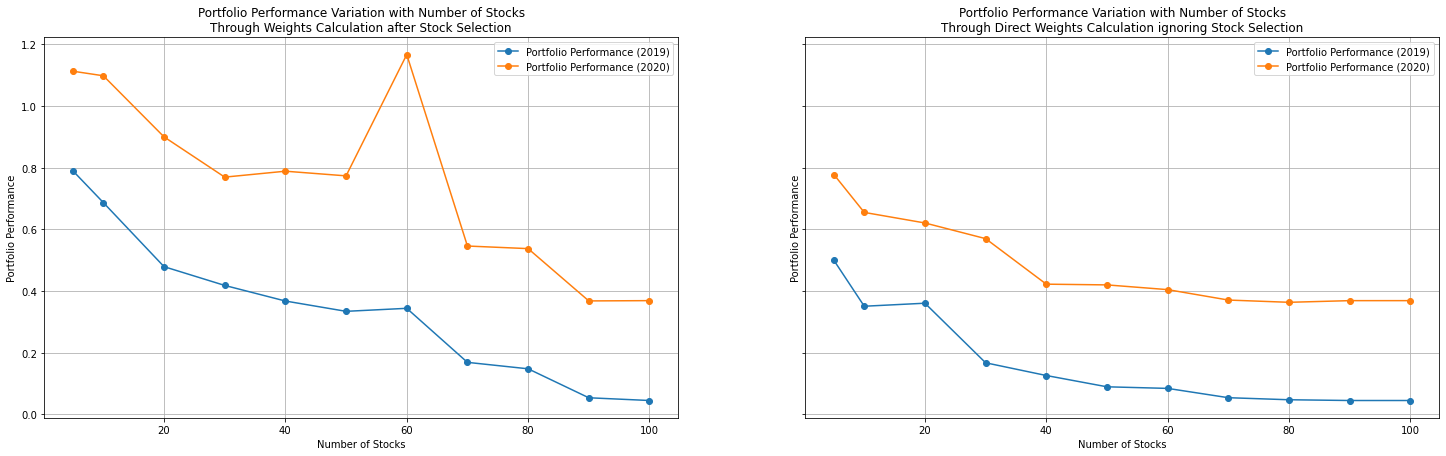

In [11]:
print('Since Portfolio Performance is measured as the absolute value of the difference in returns, a lower value is desirable.')

# Plot Performance vs Number of Stocks for both Methods

fig, (ax1, ax2) = plt.subplots(figsize = (25,7), sharey = True, nrows = 1, ncols = 2)

ax1.plot(df_perf_indirect['No of Stocks'], df_perf_indirect['2019 Performance'], marker = 'o', label = 'Portfolio Performance (2019)')
ax1.plot(df_perf_indirect['No of Stocks'], df_perf_indirect['2020 Performance'], marker = 'o', label = 'Portfolio Performance (2020)')
ax1.set_title('Portfolio Performance Variation with Number of Stocks\nThrough Weights Calculation after Stock Selection')
ax1.set_xlabel('Number of Stocks')
ax1.set_ylabel('Portfolio Performance')
ax1.grid()
ax1.legend()

ax2.plot(df_perf_direct['No of Stocks'], df_perf_direct['2019 Performance'], marker = 'o', label = 'Portfolio Performance (2019)')
ax2.plot(df_perf_direct['No of Stocks'], df_perf_direct['2020 Performance'], marker = 'o', label = 'Portfolio Performance (2020)')
ax2.set_title('Portfolio Performance Variation with Number of Stocks\nThrough Direct Weights Calculation ignoring Stock Selection')
ax2.set_xlabel('Number of Stocks')
ax2.set_ylabel('Portfolio Performance')
ax2.legend()
ax2.grid()

plt.show()

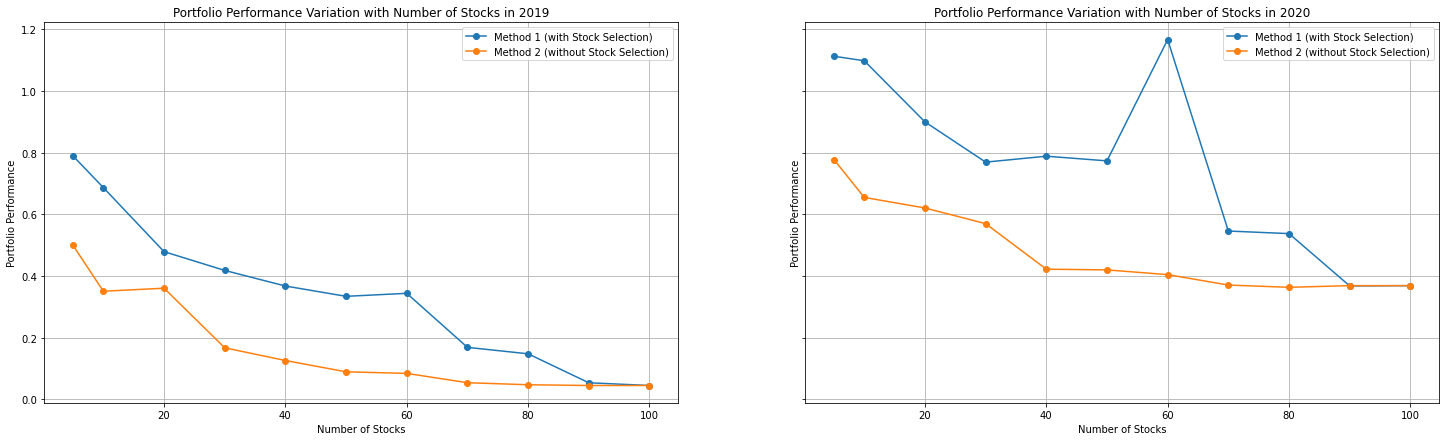

In [12]:
# Plot Performance vs Number of Stocks for both Methods

fig, (ax1, ax2) = plt.subplots(figsize = (25,7), sharey = True, nrows = 1, ncols = 2)

ax1.plot(df_perf_indirect['No of Stocks'], df_perf_indirect['2019 Performance'], marker = 'o', label = 'Method 1 (with Stock Selection)')
ax1.plot(df_perf_direct['No of Stocks'], df_perf_direct['2019 Performance'], marker = 'o', label = 'Method 2 (without Stock Selection)')
ax1.set_title('Portfolio Performance Variation with Number of Stocks in 2019')
ax1.set_xlabel('Number of Stocks')
ax1.set_ylabel('Portfolio Performance')
ax1.grid()
ax1.legend()

ax2.plot(df_perf_indirect['No of Stocks'], df_perf_indirect['2020 Performance'], marker = 'o', label = 'Method 1 (with Stock Selection)')
ax2.plot(df_perf_direct['No of Stocks'], df_perf_direct['2020 Performance'], marker = 'o', label = 'Method 2 (without Stock Selection)')
ax2.set_title('Portfolio Performance Variation with Number of Stocks in 2020')
ax2.set_xlabel('Number of Stocks')
ax2.set_ylabel('Portfolio Performance')
ax2.legend()
ax2.grid()

plt.show()

### Conclusion

#### Method 1:

In 2019, the performance of choosing 60 stocks was worse than choosing only 50 stocks. In 2020, there are diminishing returns after choosing 30 stocks as the loss stays stagnant and it even increases between m = 50 through m = 70. As a result, an optimal number of stocks would be to choose 30 stocks to model the NASDAQ-100 index.

#### Method 2:

Using this method, the performance keeps improving with an increasing number of stocks. In 2019, there is a single exception where the performance of choosing 20 stocks was worse than choosing only 10 stocks. In 2020, there are diminishing returns after choosing 40 stocks as the loss stays stagnant after. As a result, an optimal number of stocks would be to choose 40 stocks to model the NASDAQ-100 index.

#### Final Recommendation

It is clear from the above plot that Method 2 works better on the 2020 data. The performance is similar across both methods, however there is a lot more variance with Method 1 as the loss fluctuates with a higher magnitude.  Since Method 2 is better, our final recommendation is to choose 40 stocks to model the NASDAQ-100 index and model the optimization to directly calculate the weights without first selecting the stocks, i.e., use the Second Method going forward. We can improve our model by calculating the cost of adding more stocks to our portfolio and modelling the cost into our optimization constraints.
